<img src='http://imgur.com/1ZcRyrc.png' style='float: left; margin: 20px; height: 55px'>

# Project 4a: Predicting the Spread of West Nile Virus

## Part 3 - Pre-processing & Modelling

---
## Contents
---

### [Part 1 - Data Cleaning](Part%202%20-%20Data%20Cleaning.ipynb)
1. Import
2. Cleaning - Data Frame and Text

### [Part 2 - Exploratory Data Analysis & Feature Engineering](Part%203%20-%20Exploratory%20Data%20Analysis%20(EDA).ipynb)
1. Import
2. Exploratory Data Analysis - Trends
3. Exploratory Data Analysis - Unigrams 
4. Exploratory Data Analysis - Bigrams
5. Exploratory Data Analysis - Trigrams 

### [Part 3 - Pre-processing & Modelling](Part%204%20-%20Pre-processing%20&%20Modelling.ipynb)
1. [Pre-processing](#1.-Pre-processing)
2. [Modelling](#2.-Modelling)
3. [Kaggle Submission](#3.-Kaggle-Submission)
4. [Conclusion](#4.-Conclusion)

---
## 1. Pre-processing
---

### 1a. Import Libraries

In [18]:
# Import basic libraries
import pandas as pd #used
import numpy as np #used

# Import visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import json

# Import imblearn libraries
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

# Import sklearn libraries
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.neighbors import BallTree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
#from rgf.sklearn import RGFClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Import other modelling libraries
#from catboost import CatBoostClassifier
import xgboost as xgb

# Import analysis tools
from dython.nominal import identify_nominal_columns, associations

In [2]:
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyClassifier
from lazypredict.Supervised import LazyRegressor


In [ ]:
# some display adjustments to account for the fact that we have many columns
# and some columns contain many characters

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 800)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1b. Import Data

In [3]:
# Import train_df.csv from previous notebook
train_df = pd.read_csv('../data/train_cleaned.csv', index_col=0)

# Import test.csv from previous notebook
test = pd.read_csv('../data/test.csv', index_col=0)

# Import weather_df.csv from previous notebook
weather_df = pd.read_csv('../data/weather_cleaned.csv', index_col=0)

# Import weather_df.csv from previous notebook
spray_df = pd.read_csv('../data/spray_cleaned.csv', index_col=0)

In [4]:
# Display dataframes
print("train_df")
display(train_df.head())

print("test")
display(test.head())

print("weather_df")
display(weather_df.head())

print("spray_df")
display(spray_df.head())

train_df


,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0


test


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Id,,,,,,,,,,
1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9


weather_df


,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,gr,hz,mifg,ra,sn,sq,ts,tsra,vcfg,vcts
0,1,2007-05-01,83,50,67,14,51,56.00,0,2,...,0,0,0,0,0,0,0,0,0,0
1,2,2007-05-01,84,52,68,M,51,57.00,0,3,...,0,0,0,0,0,0,0,0,0,0
2,1,2007-05-02,59,42,51,-3,42,47.00,14,0,...,0,0,0,0,0,0,0,0,0,0
3,2,2007-05-02,60,43,52,M,42,47.00,13,0,...,0,1,0,0,0,0,0,0,0,0
4,1,2007-05-03,66,46,56,2,40,48.00,9,0,...,0,0,0,0,0,0,0,0,0,0


spray_df


,date,latitude,longitude
0,2011-08-29,42.39,-88.09
1,2011-08-29,42.39,-88.09
2,2011-08-29,42.39,-88.09
3,2011-08-29,42.39,-88.09
4,2011-08-29,42.39,-88.09


In [ ]:
train_df.describe()

### Train-Test-Split

In [7]:
# Assemble X and y features
X = train_df.drop(columns=['wnvpresent'])
y = train_df['wnvpresent']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# Check the proportion of 2 classes in y
y_counts = y.value_counts()
y_counts

0    9955
1     551
Name: wnvpresent, dtype: int64

### Check for imbalance

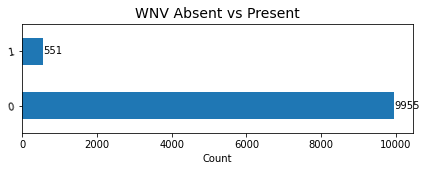

In [9]:
# Plot a horizontal bar graph to visualize the count
ax = y_counts.plot(kind='barh', figsize=(7,2))
plt.title('WNV Absent vs Present', fontsize=14)
plt.xlabel('Count', fontsize=10)
ax.set_yticklabels(y_counts.index, rotation=10)

for i, v in enumerate(y_counts):
    ax.text(v + 10, i, str(v), color='black', fontsize=10, va='center')

---
## 2. Modelling
---

pipeline
gridsearch

In [32]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display dataframe values to 4 decimal figures
pd.options.display.float_format = '{:.5f}'.format
models.sort_values(by='Accuracy', ascending=False)


100%|██████████| 29/29 [00:06<00:00,  4.72it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.94975,0.57102,0.57102,0.93620,0.24711
BernoulliNB,0.94899,0.50000,0.50000,0.92415,0.02366
SVC,0.94899,0.50000,0.50000,0.92415,0.53868
CalibratedClassifierCV,0.94899,0.50000,0.50000,0.92415,1.13268
RidgeClassifierCV,0.94899,0.50000,0.50000,0.92415,0.03800
DummyClassifier,0.94899,0.50000,0.50000,0.92415,0.02238
PassiveAggressiveClassifier,0.94861,0.50686,0.50686,0.92541,0.03641
LinearDiscriminantAnalysis,0.94823,0.50313,0.50313,0.92450,0.04497
LogisticRegression,0.94785,0.49940,0.49940,0.92358,0.06071


In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

### Logistic Regression

### Random Forest

Random Forest
XGBoost
Support Vector Machines (SVM)
K Nearest Neighbours (KNN)
AdaBoost Classifier

### 

---
## 3. Kaggle Submission
---

#### Kaggle Score

Private score: 

Public score: 

---
## 4. Conclusion
---

### 4a. Summary

### 4b. Recommendations

---
[Back to top](#Contents) | [Part 1](part_1.ipynb) | [Part 2](part_2.ipynb) | [Part 3](part_3.ipynb)